In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

In [2]:
def pre_process_data(
    input_df: pd.DataFrame, spain_provinces: pd.DataFrame, year: int
) -> pd.DataFrame:
    # find thw row in the first column with the value "Provincias y Comunidades Autónomas"
    # and get the index of that row
    first_index = input_df[
        input_df.iloc[:, 0] == "Provincias y Comunidades Autónomas"
    ].index[0]

    input_df = input_df[first_index + 1 :]

    # reanme the columns to: province, extra, virgen, lampante, total
    input_df.columns = ["province", "extra", "virgen", "lampante", "total"]

    # drop the rows where the province is NaN
    input_df = input_df.dropna(subset=["province"])

    # convert data types of the extra, virgen, lampante and total columns to float
    input_df[["extra", "virgen", "lampante", "total"]] = input_df[
        ["extra", "virgen", "lampante", "total"]
    ].apply(pd.to_numeric)

    # fill the NaN values in the extra, virgen, lampante and total columns with 0
    input_df = input_df.fillna(0)

    provinces_data = input_df[
        input_df["province"].isin(spain_provinces["Province"])
    ].sort_values(by="province")

    provinces_data["year"] = year

    return provinces_data

In [3]:
spain_provinces = pd.read_csv("../data/maps/spain_provinces.csv")

In [4]:
dfs_list = []

for year in range(2015, 2024):
    df = pd.read_excel(f"../data/yield-data/{year}.xlsx", na_values=["–"])
    df_processed = pre_process_data(df, spain_provinces, year)

    dfs_list.append(df_processed)

In [5]:
all_df = pd.concat(dfs_list)

<Axes: xlabel='year'>

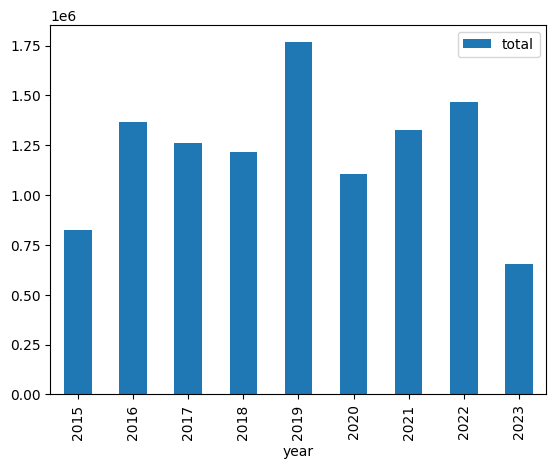

In [6]:
all_df.groupby(by="year").aggregate({"total": "sum"}).sort_index().plot(kind="bar")

In [9]:
spain_map = gpd.read_file("../data/maps/spain-map.geojson")

In [10]:
spain_map.head()

,id,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,ADM2_CODE,ADM2_NAME,DISP_AREA,EXP2_YEAR,STATUS,STR2_YEAR,Shape_Area,Shape_Leng,geometry
0,0000000000000000261b,229,Spain,2716,Andalucía,25776,Almería,NO,3000,Member State,1000,0.886192,5.757459,"MULTIPOLYGON (((-3.04429 35.94359, -3.04257 35..."
1,0000000000000000261c,229,Spain,2716,Andalucía,25777,Cádiz,NO,3000,Member State,1000,0.740346,6.353672,"MULTIPOLYGON (((-5.61149 36.00485, -5.60918 36..."
2,0000000000000000261d,229,Spain,2716,Andalucía,25778,Córdoba,NO,3000,Member State,1000,1.412444,8.316528,"MULTIPOLYGON (((-5.08497 37.64379, -5.08421 37..."
3,0000000000000000261e,229,Spain,2716,Andalucía,25779,Granada,NO,3000,Member State,1000,1.281927,7.149425,"POLYGON ((-3.14019 36.78779, -3.13982 36.78802..."
4,0000000000000000261f,229,Spain,2716,Andalucía,25780,Huelva,NO,3000,Member State,1000,1.019158,7.582351,"MULTIPOLYGON (((-6.90102 37.15554, -6.90098 37..."


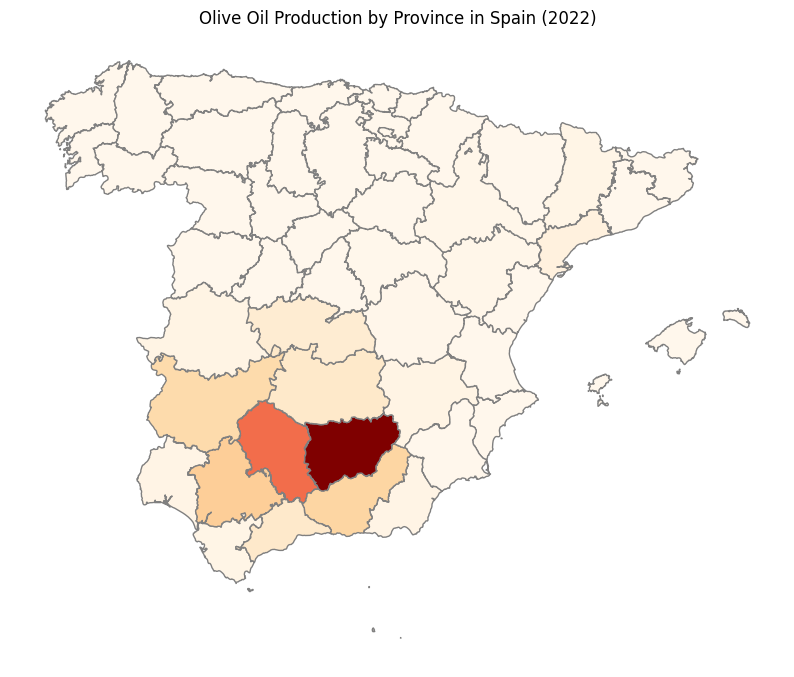

In [45]:
import matplotlib.pyplot as plt

(
    spain_map.loc[spain_map["ADM1_NAME"] != "Canarias"]
    .merge(
        all_df.query("year == 2022"),
        left_on="ADM2_NAME",
        right_on="province",
        how="left",
    )
    .loc[:, ["province", "total", "geometry"]]
    .fillna(0.0)
    .plot(column="total", cmap='OrRd', legend=False, edgecolor='gray', figsize=(10, 10))
)
plt.axis('off')
plt.title('Olive Oil Production by Province in Spain (2022)')
plt.show()
